## Trend Following System 1
Most of the following imports are mainstream, well known Python libraries.

alpha_vantage and fix_yahoo are specialist libraries to download stock data free.  To use alpha_vantage you will need to obtain your own key from the providers https://www.alphavantage.co/

ffn is a specialist library to report trading systems statistics

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib notebook
import pandas as pd
import datetime as datetime
from alpha_vantage.timeseries import TimeSeries
import fix_yahoo_finance as yf
#because the is_list_like is moved to pandas.api.types
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn
pd.set_option("max_colwidth", 100)
pd.set_option("display.max_rows", 100000)
pd.set_option("display.max_columns", 1000)
#import pixiedust

The following two cells can be used to download stock data and then blanked out again once the data has been saved to csv.

The following line is to create split adjusted Open prices since only the adjusted close is provided:

data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)

In [2]:
#ts = TimeSeries(key='insert own key', output_format='pandas')
#data, meta_data = ts.get_daily_adjusted(symbol='SPY', outputsize='full')
#data = yf.download("SPY", start="1970-01-01", end="2018-12-08")

In [3]:
#data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
#data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
#data.to_csv('../data/Stocks/spy.csv')
#data.head()

Chart the data to check there are no obvious problems with the split adjusted data.

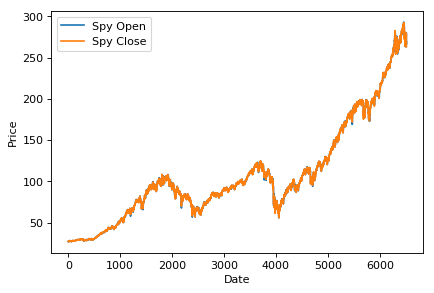

In [4]:
pricing = pd.read_csv(
    '../data/Stocks/spy.csv',
    header=0,
    parse_dates=["Date"],
    #index_col=0,
    usecols=['Date','Adj_Open', 'Adj_Close'])
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pricing.Adj_Open, label='Spy Open')
plt.plot(pricing.Adj_Close, label='Spy Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [5]:
pricing.head()

Date  Adj_Close   Adj_Open
0 1993-01-29  27.112253  27.131505
1 1993-02-01  27.305082  27.131502
2 1993-02-02  27.362904  27.285771
3 1993-02-03  27.652185  27.401472
4 1993-02-04  27.767893  27.748579

Shift the Adjusted Close down one row so that it aligns with the next day's Adjusted Open.  That way we can calculate the signals using the previous day's Close and enter the trade on the next day's Open

In [6]:
stock=pricing.copy()
stock.Adj_Close=stock.Adj_Close.shift(1)
stock.tail()

Date   Adj_Close    Adj_Open
6508 2018-11-30  273.980011  273.809998
6509 2018-12-03  275.649994  280.279999
6510 2018-12-04  279.299988  278.369995
6511 2018-12-06  270.250000  265.920013
6512 2018-12-07  269.839996  269.459991

Create three or more separate blocks of data for testing. Reserve one of these for out of sample testing.

In [37]:
stock_1=stock.iloc[0:2170].copy()
stock_2=stock.iloc[2170:4342].copy().reset_index(drop=True)
stock_3=stock.iloc[4342:6513].copy().reset_index(drop=True) 
stock_2.head()

Date  Adj_Close   Adj_Open
0 2001-09-04  81.720024  81.505194
1 2001-09-05  81.197357  81.397842
2 2001-09-06  81.397842  80.646166
3 2001-09-07  79.300270  78.763331
4 2001-09-10  77.832664  77.102443

Here is the code for the actual function which loops through the stock data and executes the trades.  You can experiment with different parameters such as changing the maximum position size or starting capital.

In [358]:
# Trade using a simple trend following strategy
def trade(stock, length):

    temp_dict = {}
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # Compute rolling mean and rolling standard deviation
    rolling_window = stock.Adj_Close.rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()

    #If you don't use a maximum position size the positions will keep on pyramidding.
    #Set max_position to a high number (1000?) to disable this parameter
    max_position =1
    
    #Slippage and commission adjustment  - simply reduces equity by a percentage guess
    slippage_adj=0.99

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock.Adj_Close - mu) / std

    # Simulate trading
    # Start with your chosen starting capital and no positions
    money = 30
    position_count = 0

    for i, row in enumerate(stock.itertuples(),0):

        # Sell short if the z-score is > 1
        if zscores[i] >  1 and position_count < max_position:
            money -= stock.Adj_Open[i] *(1/slippage_adj)
            position_count += 1
        # Buy long if the z-score is < 1
        elif zscores[i] < -1 and position_count > max_position * -1:
            # print (position_count)
            money += stock.Adj_Open[i] *slippage_adj
            position_count -= 1
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            if position_count > 0:                
                money += position_count * stock.Adj_Open[i]*slippage_adj  
            elif position_count < 0: 
                money += position_count * stock.Adj_Open[i]*(1/slippage_adj)              
            position_count = 0
        #fill dictionary with the trading results.
        temp_dict[stock.Date[i]] = [
            stock.Adj_Open[i], stock.Adj_Close[i], mu[i], std[i], zscores[i],
            money, position_count,stock.Adj_Open[i] *(1/slippage_adj),stock.Adj_Open[i] *slippage_adj
        ]
    #create a dataframe to return for use in calculating and charting the trading results
    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count','buy_slippage','sell_slippage'
    ]
    pr['equity'] = pr.money + (pr.Open * pr.position_count)
    #
    return pr

The next cell calls the function. Experiment with different moving averages by altering the number in brackets.

In [359]:
moving_average=200
profit = trade(pricing, moving_average)
profit.to_csv('../data/profit.csv')

In [360]:
#copy_profit = pd.read_csv('../data/profit.csv',header=0,parse_dates=["Date"],)
#copy_profit.head(10)

In [361]:
series=profit[['equity']].copy()

In [362]:
series=series[moving_average:-1]
#series.head()

In [363]:
stats = series.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                1993-11-12
End                  2018-12-06
Risk-free rate       0.00%

Total Return         570.57%
Daily Sharpe         0.51
Daily Sortino        0.80
CAGR                 7.89%
Max Drawdown         -41.74%
Calmar Ratio         0.19

MTD                  0.00%
3m                   -9.45%
6m                   -3.04%
YTD                  -5.11%
1Y                   -2.08%
3Y (ann.)            8.53%
5Y (ann.)            5.32%
10Y (ann.)           5.59%
Since Incep. (ann.)  7.89%

Daily Sharpe         0.51
Daily Sortino        0.80
Daily Mean (ann.)    9.27%
Daily Vol (ann.)     18.25%
Daily Skew           0.03
Daily Kurt           7.84
Best Day             9.72%
Worst Day            -8.86%

Monthly Sharpe       0.58
Monthly Sortino      1.10
Monthly Mean (ann.)  8.77%
Monthly Vol (ann.)   15.21%
Monthly Skew         0.26
Monthly Kurt         1.19
Best Month           16.21%
Worst Month          -12.82%

Year

<IPython.core.display.Javascript object>


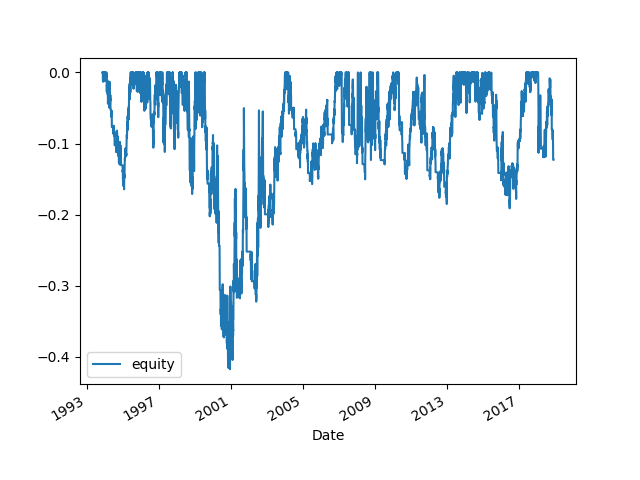

In [364]:
prices =series
ax = stats.prices.to_drawdown_series().plot()

<IPython.core.display.Javascript object>


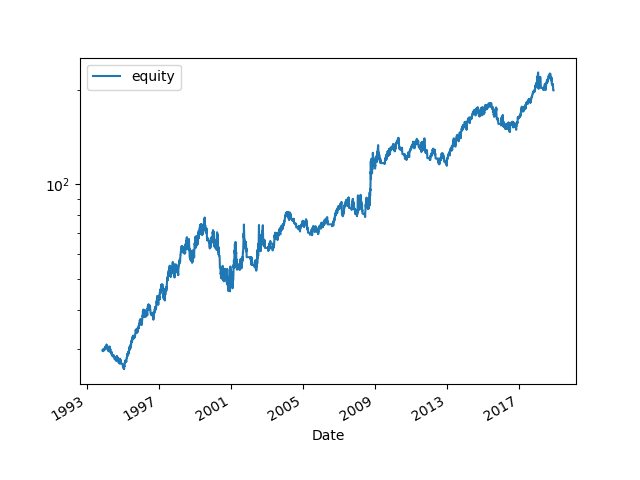

In [365]:
ax = prices.plot(logy=True)